In [1]:
import numpy as np
import cupy as cp
import matplotlib.pyplot as plt
from tqdm import tqdm
import matplotlib
matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['font.family'] = 'serif'
import healpy as hlp 

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")

from Triangle.Constants import *
from Triangle.FFTTools import *
from Triangle.Noise import *
from Triangle.Orbit import *
from Triangle.Offset import *
from Triangle.Plot import *
from Triangle.Data import *
from Triangle.GW import *
from Triangle.Interferometer import *
from Triangle.TDI import *
from Triangle.Cosmology import *

# for lisa
from fastlisaresponse import pyResponseTDI, ResponseWrapper
from astropy import units as un

# np.random.seed(114514)

In [2]:
import multiprocessing
print('number of cpus =', multiprocessing.cpu_count())
pool = multiprocessing.Pool(processes=multiprocessing.cpu_count())
# pool = None 

number of cpus = 96


# For our response

In [3]:
from scipy.interpolate import InterpolatedUnivariateSpline

class GeneralWaveform():
    def __init__(self, tdata, hpdata, hcdata, t0=0):
        tdata_int = tdata - tdata[0] + t0 # shift the starting time to t0 
        self.hpfunc = InterpolatedUnivariateSpline(x=tdata_int, y=hpdata, k=5, ext='zeros')
        self.hcfunc = InterpolatedUnivariateSpline(x=tdata_int, y=hcdata, k=5, ext='zeros')

In [4]:
waveform_data = np.load("../GWData/emritdc1.npz")
tdata, hpdata, hcdata = waveform_data['t'], waveform_data['h1'], waveform_data['h2']

waveform_wrapper = GeneralWaveform(tdata, hpdata, hcdata)

In [5]:
fsample = 1. 
data_time = 10 * DAY 
ifo_drop_time1 = 0
ifo_drop_time2 = 0
tdi_drop_time1 = 0
tdi_drop_time2 = 0
size = int((data_time + ifo_drop_time1 + ifo_drop_time2 + tdi_drop_time1 + tdi_drop_time2) * fsample)
interp_order = 15 

orbit = Orbit(OrbitDir='../OrbitData/MicroSateOrbitEclipticTCB') 
offset = OffsetFunctions(laser_flag=False, clock_flag=False) 
noise = InstrumentalPSDs(unit='ffd') 

# randomize extrinsic parameters 
lam = 4.9199374496164054
beta = 0.6147444980704073
psi = 0.11361771327484803
gw = [GW(GWfunc=waveform_wrapper, orbit=orbit, ext_params=[lam, beta, psi]),] 

ifo = Interferometers(
    size=size,
    fsample=fsample,
    time_frame='ProperTime',
    garbage_time1=ifo_drop_time1, 
    garbage_time2=ifo_drop_time2, 
    telemetry_downsample=None,
    detrend_order=None,
    acc_noise=False, 
    ro_noise=False,
    laser_noise=False,
    clock_noise=False, 
    ob_noise=False, 
    bl_noise=False,
    op_noise=False, 
    ranging_noise=False, 
    modulation_noise=False,
    orbit_class=orbit,
    offset_class=offset,
    noise_class=noise,
    gw_class=gw, 
    fplan=None,
    order=interp_order,
    pool=pool,
    clean_memory=True,
    )

ifo.SimulateInterferometers()
m = ifo.OutputMeasurements(mode='decomposed') 
ifo.clean()

m1 = TPStoTCB(m, orbit_class=orbit, order=interp_order, pool=pool) 

tdi = TDI(measurements=m1, delays=m1['ltt'], fsample=m1['fsample'], order=interp_order, delay_order=5)
tdi.CalculateXi(doppler=False, pool=pool) 
tdi.CalculateEta(doppler=False)
tdi.FastMichelson(doppler=False, channel='AET')

tdi.measurements.keys()

dict_keys(['time', 'fsample', 'ltt', 'sci_c', 'sci_sb', 'ref_c', 'ref_sb', 'tm_c', 'a', 'b', 'dpl', 'xi', 'eta', 'X0', 'X1', 'X2', 'Y0', 'Y1', 'Y2', 'Z0', 'Z1', 'Z2', 'A0', 'E0', 'T0', 'A1', 'E1', 'T1', 'A2', 'E2', 'T2'])

Text(0, 0.5, 'TDI')

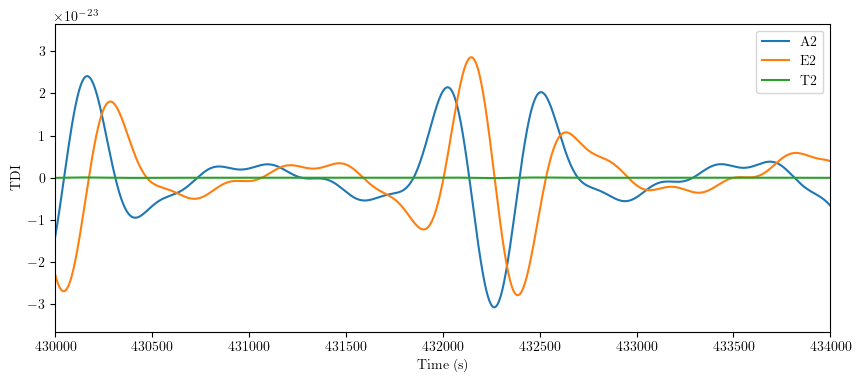

In [6]:
plt.figure(figsize=(10, 4))

for channel_name in ['A2', 'E2', 'T2']: 
    plt.plot(tdi.measurements['time']['1'][1000:-1000], tdi.measurements[channel_name][1000:-1000]/F_LASER, label=channel_name)
plt.legend()
plt.xlim(4.3e5, 4.34e5)
plt.xlabel('Time (s)')
plt.ylabel('TDI')

# For LISA response

In [7]:
class LISAWaveform():
    def __init__(self, tdata, hpdata, hcdata, t0=0):
        tdata_int = tdata - tdata[0] + t0 # shift the starting time to t0 
        self.hpfunc = InterpolatedUnivariateSpline(x=tdata_int, y=hpdata, k=5, ext='zeros')
        self.hcfunc = InterpolatedUnivariateSpline(x=tdata_int, y=hcdata, k=5, ext='zeros')

    def __call__(self, psi, T=1., dt=10.):
        
        # convert to SSB frame waveform 
        t = np.arange(0.0, T * YEAR, dt)
        cos2psi = np.cos(2.0 * psi)
        sin2psi = np.sin(2.0 * psi)

        hSp = self.hpfunc(t)
        hSc = self.hcfunc(t)

        hp = hSp * cos2psi - hSc * sin2psi
        hc = hSp * sin2psi + hSc * cos2psi

        return hp + 1j * hc

In [8]:
lisa_warpper = LISAWaveform(tdata, hpdata, hcdata)

In [9]:
use_gpu = False

T = data_time / YEAR
t0 = 1000.

dt = 1 / fsample

# 1st or 2nd or custom (see docs for custom)
tdi_gen = "2nd generation"

index_lambda = 1
index_beta = 2

orbit_file_esa = '../OrbitData/MicroSateOrbitEclipticTCB/MicroSateOrbit.hdf5'

orbit_kwargs_esa = dict(orbit_file=orbit_file_esa)

tdi_kwargs_esa = dict(
    orbit_kwargs=orbit_kwargs_esa, order=interp_order, tdi=tdi_gen, tdi_chan="AET",
)

gw_lisa_esa = ResponseWrapper(
    lisa_warpper,
    T,
    dt,
    index_lambda,
    index_beta,
    t0=t0,
    flip_hx=False,  # set to True if waveform is h+ - ihx
    use_gpu=use_gpu,
    remove_sky_coords=True,  # True if the waveform generator does not take sky coordinates
    is_ecliptic_latitude=True,  # False if using polar angle (theta)
    remove_garbage=True,  # removes the beginning of the signal that has bad information
    **tdi_kwargs_esa,
)

In [10]:
lisa_chans = gw_lisa_esa(psi, lam, beta)

Text(0, 0.5, 'TDI')

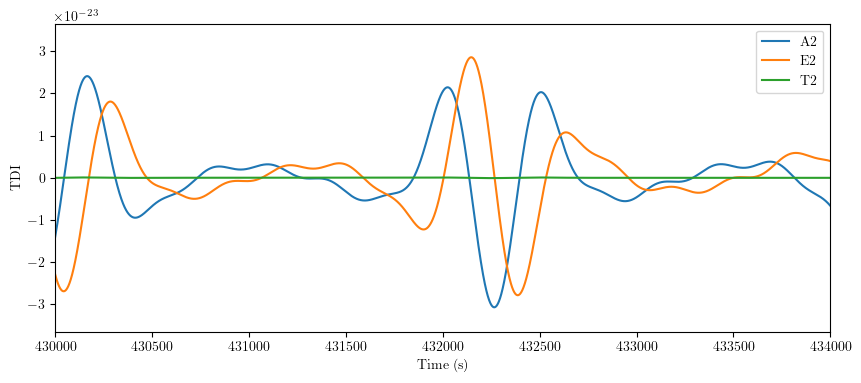

In [16]:
plt.figure(figsize=(10, 4))

plt.plot(tdi.measurements['time']['1'][1000:-1000], lisa_chans[0], label='A2')
plt.plot(tdi.measurements['time']['1'][1000:-1000], lisa_chans[1], label='E2')
plt.plot(tdi.measurements['time']['1'][1000:-1000], lisa_chans[2], label='T2')
plt.legend()
plt.xlim(4.3e5, 4.34e5)
plt.xlabel('Time (s)')
plt.ylabel('TDI')

# Residuals

Text(0, 0.5, 'TDI')

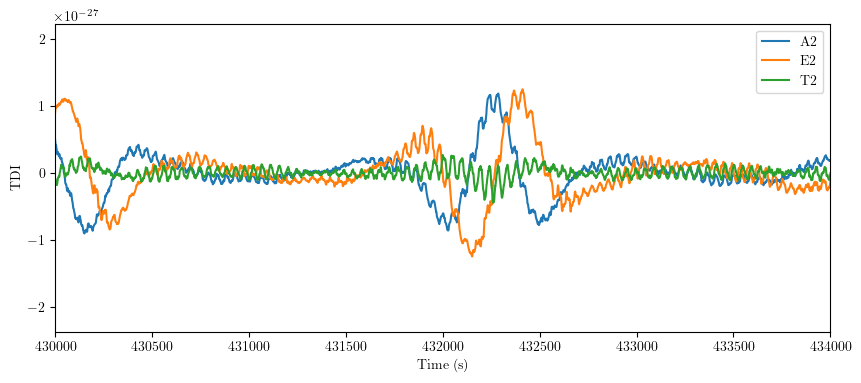

In [17]:
plt.figure(figsize=(10, 4))

plt.plot(tdi.measurements['time']['1'][1000:-1000], lisa_chans[0] - tdi.measurements['A2'][1000:-1000]/F_LASER, label='A2')
plt.plot(tdi.measurements['time']['1'][1000:-1000], lisa_chans[1] - tdi.measurements['E2'][1000:-1000]/F_LASER, label='E2')
plt.plot(tdi.measurements['time']['1'][1000:-1000], lisa_chans[2] - tdi.measurements['T2'][1000:-1000]/F_LASER, label='T2')
plt.legend()
plt.xlim(4.3e5, 4.34e5)
plt.xlabel('Time (s)')
plt.ylabel('TDI')